In [8]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import json

In [9]:
%matplotlib inline
sns.set_context("poster")

In [10]:
X_train = []
y_train = []

drives = ['V79_office_run_1.pkl', 'V79_office_run_2.pkl']
for drive in drives:
    with open('data/{}'.format(drive), 'rb') as f:
        data = pickle.load(f)
        
#     #drop some bad data I found
#     frames_to_drop = [(0,350),(1000,1120),(1390,1475),(1700,1943),
#      (2018,2025),(2140,2230), (2500,2526),(2900,2919),(2980, 2992), (3240, 3256),(3410,3446),
#      (3470,3496),(4190,4229),(4360,4382),(4530,4590),(5245,5259), (5435,5463), (5500, 6661)]
#     clean_indicies = np.ones(len(data["images"]))
#     for r in frames_to_drop:
#         clean_indicies[r[0]:r[1]] = 0
        
#     clean_indicies = clean_indicies.astype(np.bool)
#     data["images"] = data["images"][clean_indicies]
#     data["steering_throttle"] = data["steering_throttle"][clean_indicies]
    
    
    X_train.extend(data['images'])
    y_train.extend(data['steering_throttle'].astype(np.float64))
    
    X_train.extend(np.array([np.fliplr(x) for x in data['images']]))
    y_train.extend(np.negative(data['steering_throttle'].astype(np.float64)))
    
X_train = np.array(X_train)
y_train = np.array(y_train)[:,[0]]

In [11]:
print(X_train.shape, y_train.shape)

(22302, 80, 320, 3) (22302, 1)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


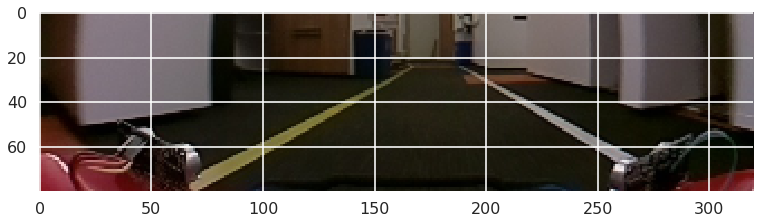

In [12]:
#view some images
plt.imshow(X_train[1100])


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


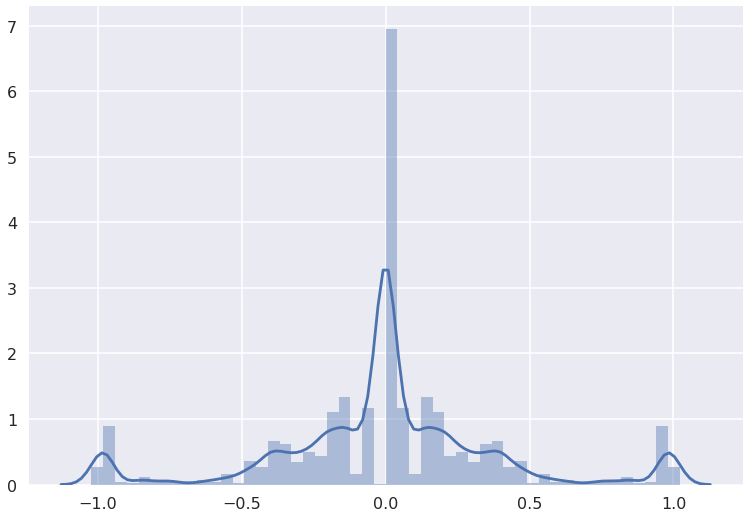

In [86]:
# now we need to evenly distribute the steering angles
# its likely there is an over bias towards straight
sns.distplot(y_train)

In [87]:
steering_bins = [x/10.0 for x in range(-10,10,1)]
steering_buckets = [[] for _ in steering_bins]
for i, y in enumerate(y_train):
    index = 0
    while index < len(steering_bins):
        if y < steering_bins[index]:
            steering_buckets[index].append(i)
            break
        index += 1
    if index  == len(steering_bins):
        steering_buckets[index-1].append(i)

print(steering_bins)
counts_buckets = [len(x) for x in steering_buckets]
print(counts_buckets)

[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[118, 666, 90, 82, 59, 152, 409, 932, 740, 1640, 825, 5351, 1058, 1322, 640, 701, 135, 76, 74, 882]


7685


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


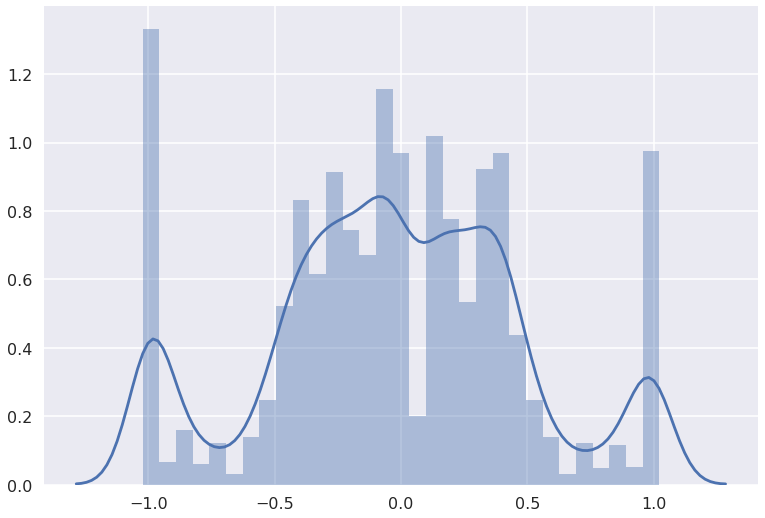

In [88]:
min_bucket = min([x for x in counts_buckets if x > 0])
#create an even distribution from the buckets
distributed_indicies = []
for bucket in steering_buckets:
    if len(bucket):
        distributed_indicies.extend(np.random.choice(bucket, min(len(bucket), min_bucket * 10), replace=False))
y_dist = y_train[distributed_indicies]
X_dist = X_train[distributed_indicies]
sns.distplot(y_dist)
print(len(y_dist))

In [89]:
def create_model():
    model = Sequential()
    
    # preprocess
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3)))
    
    # conv1 layer
    model.add(Convolution2D(32, (5, 5)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    
    # conv2 layer
    model.add(Convolution2D(64, (5, 5)))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation('relu'))
    
    # conv3 layer
    model.add(Convolution2D(128, (3, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # conv4 layer
    model.add(Convolution2D(128, (3, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    #add fully connected layers
    model.add(Flatten()) #Flatten input image
    
    # fc1
    model.add(Dense(1024))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    # fc2
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    # fc2
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(1)) #output layer with 1 regression value
    model.compile(loss="mse", optimizer="adam")

    return model

In [90]:
# #create the model and save it as json
# model = create_model()
# with open("model.json", "w") as f:
#     json.dump(model.to_json(), f)

In [93]:
#loading the model
from keras.models import model_from_json
with open("model.json") as f:
    model = model_from_json(json.load(f))
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])
model.load_weights("model.h5")  #<--simulator

In [ ]:
hist = []
for i in range(10):
    print("{} --------------".format(i))
    h = model.fit(X_train, y_train, shuffle=True, epochs=20, validation_split=.3, batch_size=128)
    hist.append(h)
    model.save("office_set_2_{}.h5".format(i))
    

0 --------------
Train on 11166 samples, validate on 4786 samples
Epoch 1/20
11166/11166 [==============================] - 34s - loss: 0.1346 - mean_absolute_error: 0.2515 - val_loss: 0.0736 - val_mean_absolute_error: 0.2001
Epoch 2/20
11166/11166 [==============================] - 32s - loss: 0.0483 - mean_absolute_error: 0.1524 - val_loss: 0.0320 - val_mean_absolute_error: 0.1228
Epoch 3/20
11166/11166 [==============================] - 32s - loss: 0.0134 - mean_absolute_error: 0.0807 - val_loss: 0.0165 - val_mean_absolute_error: 0.0872
Epoch 12/20
11166/11166 [==============================] - 33s - loss: 0.0139 - mean_absolute_error: 0.0826 - val_loss: 0.0157 - val_mean_absolute_error: 0.0838
Epoch 13/20
11166/11166 [==============================] - 32s - loss: 0.0138 - mean_absolute_error: 0.0813 - val_loss: 0.0154 - val_mean_absolute_error: 0.0884
Epoch 14/20
11166/11166 [==============================] - 32s - loss: 0.0127 - mean_absolute_error: 0.0791 - val_loss: 0.0176 - val

11166/11166 [==============================] - 33s - loss: 0.0099 - mean_absolute_error: 0.0662 - val_loss: 0.0193 - val_mean_absolute_error: 0.0911
Epoch 8/20
11166/11166 [==============================] - 33s - loss: 0.0114 - mean_absolute_error: 0.0721 - val_loss: 0.0150 - val_mean_absolute_error: 0.0826
Epoch 9/20
11166/11166 [==============================] - 33s - loss: 0.0106 - mean_absolute_error: 0.0691 - val_loss: 0.0177 - val_mean_absolute_error: 0.0895
Epoch 10/20
11166/11166 [==============================] - 33s - loss: 0.0094 - mean_absolute_error: 0.0654 - val_loss: 0.0155 - val_mean_absolute_error: 0.0825
Epoch 11/20
11166/11166 [==============================] - 33s - loss: 0.0100 - mean_absolute_error: 0.0668 - val_loss: 0.0175 - val_mean_absolute_error: 0.0886
Epoch 12/20
11166/11166 [==============================] - 33s - loss: 0.0093 - mean_absolute_error: 0.0645 - val_loss: 0.0158 - val_mean_absolute_error: 0.0836
Epoch 13/20
11166/11166 [=======================

In [64]:
history

import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import json
%matplotlib inline
sns.set_context("poster")
X_train = []
y_train = []

drives = ['V79_office_run_1.pkl']
for drive in drives:
    with open(drive, 'rb') as f:
        data = pickle.load(f)
        
#     #drop some bad data I found
#     frames_to_drop = [(0,350),(1000,1120),(1390,1475),(1700,1943),
#      (2018,2025),(2140,2230), (2500,2526),(2900,2919),(2980, 2992), (3240, 3256),(3410,

In [11]:
predicted = model.predict(X_train)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


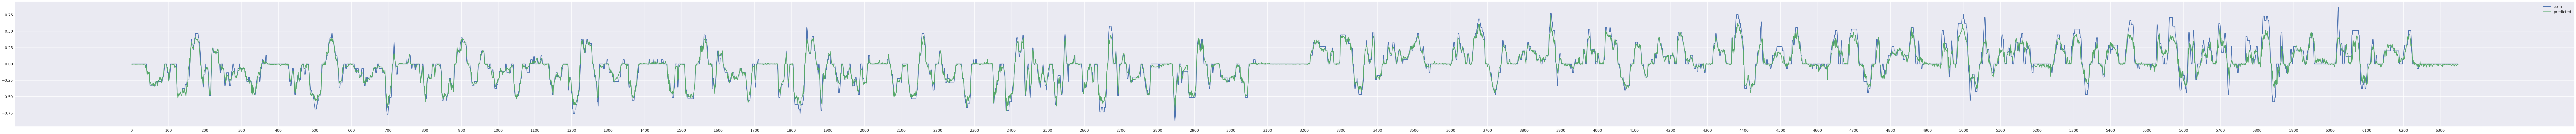

In [12]:
#visual actual vs predicted
plt.figure(figsize=(200,10))
plt.plot(y_train, label="train")
plt.plot(predicted, label="predicted")
plt.xticks()
plt.legend()
plt.xticks(np.arange(0,len(X_train), 100))
plt.show()

In [21]:
frame = 1980

frame 2021 actual [ 0.] predict 0.0144395045936


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


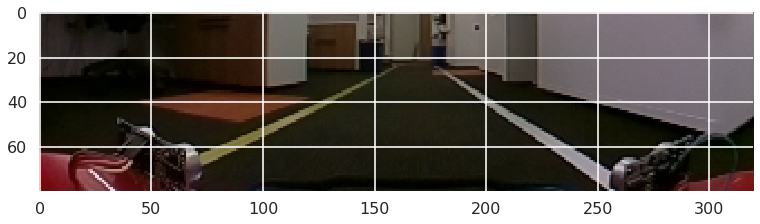

In [63]:
#inference
img = X_train[frame]
actual = y_train[frame]
print("frame",frame,"actual", actual * 45, "predict", model.predict(np.array([img]))[0][0] * 45)
plt.imshow(img)
frame += 1

In [15]:
model.predict(np.array([img]))[0][0] * 45

-13.44682440161705

In [209]:
0.04938826 * 45

2.2224717000000003